In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import itertools
import seaborn as sns
%matplotlib inline
import plotly.express as px
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller, acf, pacf,arma_order_select_ic
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.api import VAR
from statsmodels.tsa.stattools import grangercausalitytests
from statsmodels.tools.eval_measures import rmse, aic
import warnings
warnings.simplefilter('ignore')

In [249]:

list = ['Date', 'State', 'District', 'Confirmed','Recovered','Deceased']
df= pd.read_csv('output-Copy1.csv', usecols=list)
df=df.loc[df.District=='Anantapur',:]
df['Date'] = pd.to_datetime(df['Date']).dt.normalize()
# df = df.groupby('Date')[['Confirmed','Recovered','Deceased']].sum().reset_index()
df

,Date,State,District,Confirmed,Recovered,Deceased
0,2020-04-26,Andhra Pradesh,Anantapur,53,14,4
1,2020-04-27,Andhra Pradesh,Anantapur,53,14,4
2,2020-04-28,Andhra Pradesh,Anantapur,54,14,4
3,2020-04-29,Andhra Pradesh,Anantapur,58,17,4
4,2020-04-30,Andhra Pradesh,Anantapur,61,20,4
...,...,...,...,...,...,...
158,2020-10-01,Andhra Pradesh,Anantapur,57708,55406,491
159,2020-10-02,Andhra Pradesh,Anantapur,58041,55934,495
160,2020-10-03,Andhra Pradesh,Anantapur,58323,56420,497
161,2020-10-04,Andhra Pradesh,Anantapur,58734,56869,502


In [250]:
df=df.loc[:,['Date', 'Confirmed','Recovered','Deceased']]
# df=df.set_index(['Date'])
#Granger causality
def grangers_causation_matrix(data, variables, test='ssr_chi2test', verbose=False, maxlag=5):    
    
    """Check Granger Causality of all possible combinations of the Time series.
    The rows are the response variable, columns are predictors. 

    data      : pandas dataframe containing the time series variables
    variables : list containing names of the time series variables.
    """
    df = pd.DataFrame(np.zeros((len(variables), len(variables))), columns=variables, index=variables)
    for c in df.columns:
        for r in df.index:
            test_result = grangercausalitytests(data[[r, c]], maxlag=maxlag, verbose=False)
            p_values = [round(test_result[i+1][0][test][1],4) for i in range(maxlag)]
            if verbose: print(f'Y = {r}, X = {c}, P Values = {p_values}')
            min_p_value = np.min(p_values)
            df.loc[r, c] = min_p_value
    df.columns = [var + '_x' for var in variables]
    df.index = [var + '_y' for var in variables]
    return df  
grangers_causation_matrix(df, variables = ['Confirmed','Recovered','Deceased']) 

,Confirmed_x,Recovered_x,Deceased_x
Confirmed_y,1.0,0.0,0.0
Recovered_y,0.0,1.0,0.0
Deceased_y,0.0,0.0,1.0


In [251]:
from statsmodels.tsa.vector_ar.vecm import coint_johansen

def cointegration_test(df, alpha=0.05): 
    """Perform Johanson's Cointegration Test and Report Summary"""
    out = coint_johansen(df,-1,5)
    d = {'0.90':0, '0.95':1, '0.99':2}
    traces = out.lr1
    cvts = out.cvt[:, d[str(1-alpha)]]
    def adjust(val, length= 6): return str(val).ljust(length)

    # Summary
    print('Name   ::  Test Stat > C(95%)    =>   Signif  \n', '--'*20)
    for col, trace, cvt in zip(df.columns, traces, cvts):
        print(adjust(col), ':: ', adjust(round(trace,2), 9), ">", adjust(cvt, 8), ' =>  ' , trace > cvt)
cointegration_test(df[['Confirmed','Recovered','Deceased']])

Name   ::  Test Stat > C(95%)    =>   Signif  
 ----------------------------------------
Confirmed ::  53.68     > 24.2761   =>   True
Recovered ::  23.92     > 12.3212   =>   True
Deceased ::  0.86      > 4.1296    =>   False


In [252]:
df['Confirmed logFirst Difference'] =(np.log(df['Confirmed'])-np.log(df['Confirmed']).shift(1)).ewm(20).mean()
# df['Confirmed logFirst sum'] =(np.log(df['Confirmed'])+np.log(df['Confirmed']).shift(1)).ewm(20).mean()
# df['Confirmed temp']=(np.exp(df['Confirmed logFirst Difference'] + df['Confirmed logFirst sum'] ))** 0.5
df['Recovered logFirst Difference'] =(np.log(df['Recovered'])-np.log(df['Recovered']).shift(1)).ewm(20).mean()
# df['Recovered logFirst sum'] =(np.log(df['Recovered'])+np.log(df['Recovered']).shift(1)).ewm(20).mean()

df['Deceased logFirst Difference'] = (np.log(df['Deceased'])-np.log(df['Deceased']).shift(1)).ewm(20).mean()
# df['Deceased logFirst sum'] =(np.log(df['Deceased'])-np.log(df['Deceased']).shift(1)).ewm(20).mean()


df=df[~df.isin([np.nan, np.inf, -np.inf]).any(1)]
dftemp=df.copy()
df=df.drop(['Confirmed','Recovered','Deceased'],axis=1)
df

,Date,Confirmed logFirst Difference,Recovered logFirst Difference,Deceased logFirst Difference
1,2020-04-27,0.000000,0.000000,0.000000
2,2020-04-28,0.009574,0.000000,0.000000
3,2020-04-29,0.031217,0.067901,0.000000
4,2020-04-30,0.036377,0.093314,0.000000
5,2020-05-01,0.049013,0.093753,0.000000
...,...,...,...,...
158,2020-10-01,0.016032,0.020809,0.017194
159,2020-10-02,0.015542,0.020270,0.016761
160,2020-10-03,0.015033,0.019716,0.016155
161,2020-10-04,0.014651,0.019154,0.015862


In [253]:


train=df[:120]

test=df[120:]
testtemp=dftemp[120:]

train = train.set_index(['Date'])
test = test.set_index(['Date'])
testtemp = testtemp.set_index(['Date'])

ts1=train
testFinl=test.copy()
def roll(col):
    ts=ts1.loc[:,[col]]
    ts.astype('int64')
    return (ts.rolling(window=4,center=False).mean().dropna())


def rollPlot(col):
    ts=ts1.loc[:,[col]]
    ts.astype('int64')
    plt.figure(figsize=(16,6))
    plt.plot(ts.rolling(window=4,center=False).mean().dropna(),label='Rolling Mean')
    plt.plot(ts[col])
    plt.plot(ts.rolling(window=4,center=False).std(),label='Rolling std')
    plt.legend()
    plt.title(col+'Cases distribution with rolling mean and standard' )
    plt.xticks([])


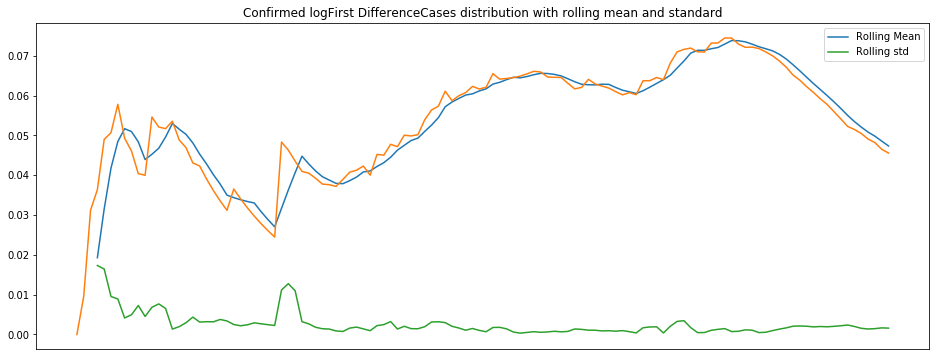

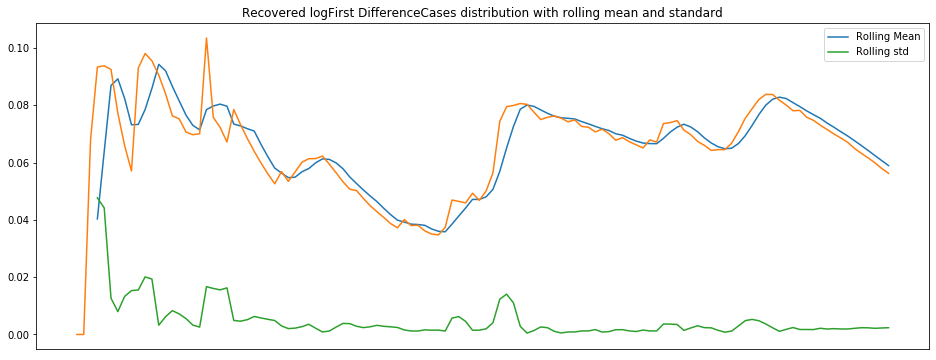

In [254]:
rollPlot('Confirmed logFirst Difference')
rollPlot('Recovered logFirst Difference')

# df.plot()

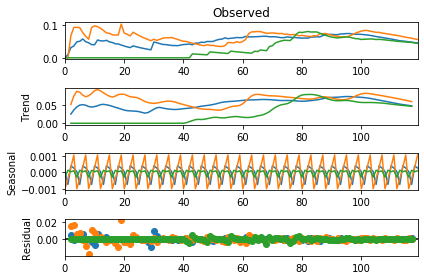

In [255]:
fig=sm.tsa.seasonal_decompose(train.values,freq=4).plot()

In [256]:
#Function to check the stationarity of the time serie using Dickey fuller test
def stationarity(ts):
    print('Results of Dickey-Fuller Test:')
    test = adfuller(ts, autolag='AIC')
    results = pd.Series(test[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for i,val in test[4].items():
        results['Critical Value (%s)'%i] = val
    print (results)
tsC2=train['Confirmed logFirst Difference'].values 
tsR2=train['Recovered logFirst Difference'].values 
tsD2=train['Deceased logFirst Difference'].values 

stationarity(tsC2)
stationarity(tsR2)
stationarity(tsD2)

Results of Dickey-Fuller Test:
Test Statistic                  -4.026316
p-value                          0.001279
#Lags Used                       0.000000
Number of Observations Used    119.000000
Critical Value (1%)             -3.486535
Critical Value (5%)             -2.886151
Critical Value (10%)            -2.579896
dtype: float64
Results of Dickey-Fuller Test:
Test Statistic                  -2.118451
p-value                          0.237160
#Lags Used                      11.000000
Number of Observations Used    108.000000
Critical Value (1%)             -3.492401
Critical Value (5%)             -2.888697
Critical Value (10%)            -2.581255
dtype: float64
Results of Dickey-Fuller Test:
Test Statistic                  -1.073050
p-value                          0.725699
#Lags Used                       2.000000
Number of Observations Used    117.000000
Critical Value (1%)             -3.487517
Critical Value (5%)             -2.886578
Critical Value (10%)            -2.58

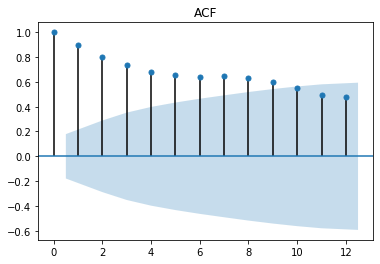

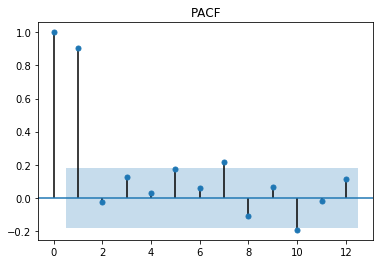

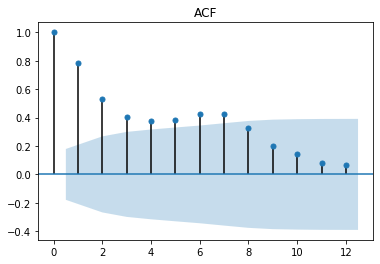

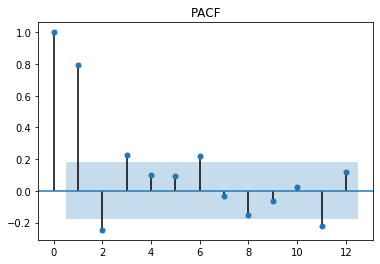

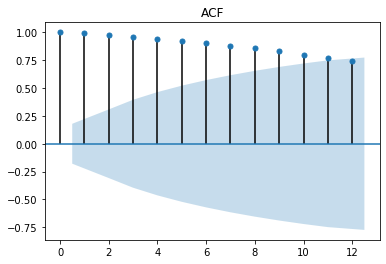

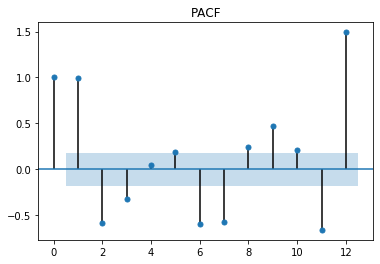

In [257]:
def corr(ts):
    plot_acf(ts,lags=12,title="ACF")
    plot_pacf(ts,lags=12,title="PACF")
    

corr(tsC2)
corr(tsR2)
corr(tsD2)



In [258]:
model=VAR(train)

In [259]:
fitted=model.fit(maxlags=20,ic='bic')
fitted.summary()


  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Sun, 27, Dec, 2020
Time:                     00:16:00
--------------------------------------------------------------------
No. of Equations:         3.00000    BIC:                   -32.0561
Nobs:                     119.000    HQIC:                  -32.2226
Log likelihood:           1429.45    FPE:                9.04736e-15
AIC:                     -32.3364    Det(Omega_mle):     8.19308e-15
--------------------------------------------------------------------
Results for equation Confirmed logFirst Difference
                                      coefficient       std. error           t-stat            prob
---------------------------------------------------------------------------------------------------
const                                    0.009290         0.001846            5.031           0.000
L1.Confirmed logFirst Difference         0.861553         0.

In [260]:
# Get the lag order
lag_order = fitted.k_ar

# Input data for forecasting
forecast_input = test.values[-lag_order:]
forecast_input
# #fitted.plot_forecast(start=len(ts), end=len(ts)+len(test))
pred=fitted.forecast(forecast_input ,len(test.dropna()))
test['predictedconfirmedlog']=pred[:,0]
# test['predictedconfirmedlogsum']=pred[:,1]

# test['predictedcon']=(np.exp(test['predictedconfirmedlog'] + test['predictedconfirmedlogsum'] ))** 0.5

# test['predictedConfirmed']=np.exp(pred[:,0])
test['recoveredconfirmedlog']=pred[:,1]
# test['predicted log confri']=pred[:,3]


Mean absolute percentage error: 117.712309


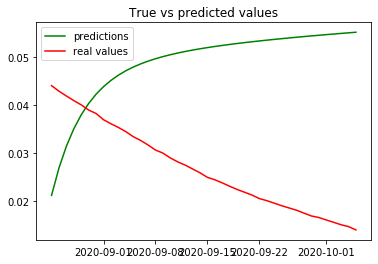

In [261]:
def mape(y2, y_pred): 
    y2, y_pred = np.array(y2), np.array(y_pred)
    return np.mean(np.abs((y2 - y_pred) / y2)) * 100
# # Get the lag order
# lag_order = fitted.k_ar

# # Input data for forecasting
# forecast_input = testFinl.values[-lag_order:]
# forecast_input
# # #fitted.plot_forecast(start=len(ts), end=len(ts)+len(test))
# pred=fitted.forecast(forecast_input ,80)

# #Plotting results
f,ax=plt.subplots()
plt.plot((test['predictedconfirmedlog']),c='green', label= 'predictions')
plt.plot((test['Confirmed logFirst Difference']), c='red',label='real values')
plt.legend()
plt.title('True vs predicted values')
print('\nMean absolute percentage error: %f'%mape(test['Confirmed logFirst Difference'],test['predictedconfirmedlog']))
# pred


In [204]:
##add granger causality and corr function
## run model for all districts
## calculate cumulative aerage mape score

In [1]:
#Granger causality
def grangers_causation_matrix(data, variables, test='ssr_chi2test', verbose=False, maxlag=5):    
    
    """Check Granger Causality of all possible combinations of the Time series.
    The rows are the response variable, columns are predictors. 

    data      : pandas dataframe containing the time series variables
    variables : list containing names of the time series variables.
    """
    df = pd.DataFrame(np.zeros((len(variables), len(variables))), columns=variables, index=variables)
    for c in df.columns:
        for r in df.index:
            test_result = grangercausalitytests(data[[r, c]], maxlag=maxlag, verbose=False)
            p_values = [round(test_result[i+1][0][test][1],4) for i in range(maxlag)]
            if verbose: print(f'Y = {r}, X = {c}, P Values = {p_values}')
            min_p_value = np.min(p_values)
            df.loc[r, c] = min_p_value
    df.columns = [var + '_x' for var in variables]
    df.index = [var + '_y' for var in variables]
    return df  


In [ ]:
grangers_causation_matrix(var_df, variables = ['TotalHospitalizedPatients', 'HomeConfinement',
                                                  'Recovered', 'Deaths', 'TestsPerformed']) 